In [1]:
import matplotlib.pyplot as plt

In [2]:
from datasets import load_dataset

# Load a dataset
dataset = load_dataset('b-mc2/sql-create-context')

In [3]:
contexts = [example['context'] for example in dataset['train']]
answers = [example['answer'] for example in dataset['train']]
questions = [example['question'] for example in dataset['train']]

In [4]:
from sklearn.model_selection import train_test_split

# Assuming contexts, answers, and questions are your dataset
data = list(zip(contexts, answers, questions))

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Unzip the data
train_contexts, train_answers, train_questions = map(list, zip(*train_data))
val_contexts, val_answers, val_questions = map(list, zip(*val_data))

In [5]:
import re

def prepare_text(text):
    text = '<START>' + text + '<END>'
    return text

train_answers = list(map(prepare_text, train_answers))

In [6]:
from tokenizers import Tokenizer, trainers, models, pre_tokenizers, decoders, processors
import tensorflow as tf

# Initialize a tokenizer
tokenizer = Tokenizer(models.BPE())

# Set padding token. Padding token must be zero.
tokenizer.add_special_tokens(["<PAD>", "<START>", "<END>"])
tokenizer.enable_padding(pad_id=0, pad_token="<PAD>")

# Gather all texts
all_texts = train_contexts + train_questions + train_answers

# Train the tokenizer
tokenizer.train_from_iterator(all_texts)

# Now you can use the tokenizer to encode your texts
prompt_tokens, answer_tokens = [], []
for context, question, answer in zip(train_contexts, train_questions, train_answers):
    prompt = question + " context: " + context
    prompt_tokens.append(tokenizer.encode(prompt).ids)
    answer_tokens.append(tokenizer.encode(answer).ids)

In [7]:
tokenizer.encode("<END>").ids

[2]

(array([3.9433e+04, 1.9802e+04, 3.1700e+03, 3.7200e+02, 6.8000e+01,
        1.1000e+01, 0.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  7. ,  19.4,  31.8,  44.2,  56.6,  69. ,  81.4,  93.8, 106.2,
        118.6, 131. ]),
 <BarContainer object of 10 artists>)

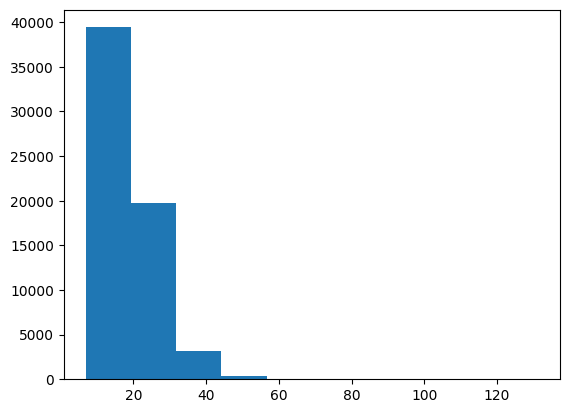

In [8]:
seq_lengths = [len(seq) for seq in prompt_tokens]
plt.hist(seq_lengths)

In [9]:
prompt_seq_length = 50  # replace with your desired sequence length
answer_seq_length = 50

# Add padding if necessary
prompt_tokens_padded = tf.keras.preprocessing.sequence.pad_sequences(prompt_tokens, maxlen=prompt_seq_length, padding='post', value=0)
answer_tokens_padded = tf.keras.preprocessing.sequence.pad_sequences(answer_tokens, maxlen=answer_seq_length, padding='post', value=0)

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
from keras_nlp.layers import ReversibleEmbedding, PositionEmbedding, TransformerEncoder, TransformerDecoder

np.random.seed(42)
tf.random.set_seed(42)

sequence_length = 50
vocab_size = tokenizer.get_vocab_size()
num_heads = 8
embedding_dim = 64
feedforward_dim = 512

encoder_input = Input(shape=(None,), dtype='int64', name='encoder_input')
encoder_token_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(encoder_input)
encoder_position_embeddings = PositionEmbedding(sequence_length=sequence_length)(encoder_token_embeddings)
encoder_embeddings = tf.keras.layers.Add()([encoder_token_embeddings, encoder_position_embeddings])
encoder_output = TransformerEncoder(feedforward_dim, num_heads)(encoder_embeddings)

decoder_input = Input(shape=(None,), dtype='int64', name='decoder_input')
decoder_token_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(decoder_input)
decoder_position_embeddings = PositionEmbedding(sequence_length=sequence_length)(decoder_token_embeddings)
decoder_embeddings = tf.keras.layers.Add()([decoder_token_embeddings, decoder_position_embeddings])
decoder_output = TransformerDecoder(feedforward_dim, num_heads)(decoder_embeddings, encoder_output)
decoder_output = Dropout(0.4)(decoder_output)

final_output = Dense(vocab_size, activation='softmax')(decoder_output)
model = Model([encoder_input, decoder_input], final_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary(line_length=120)


Using TensorFlow backend


2024-05-23 20:04:36.676076: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-05-23 20:04:36.676098: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-23 20:04:36.676102: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-23 20:04:36.676128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-23 20:04:36.676140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                       Output Shape                        Param #     Connected to                        
 encoder_input (InputLayer)         [(None, None)]                      0           []                                  
                                                                                                                        
 decoder_input (InputLayer)         [(None, None)]                      0           []                                  
                                                                                                                        
 embedding (Embedding)              (None, None, 64)                    1920128     ['encoder_input[0][0]']             
                                                                                                                        
 embedding_1 (Emb

In [11]:
inputs = { 'encoder_input': prompt_tokens_padded, 'decoder_input': answer_tokens_padded[:, :-1] }
outputs = answer_tokens_padded[:, 1:]

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath = 'model/sql_qa_model.keras'
callback_es = EarlyStopping(monitor='val_accuracy', restore_best_weights=True)
callback_mc = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(inputs, outputs, epochs=20, validation_split=0.2, callbacks=[callback_es, callback_mc])

Epoch 1/20


2024-05-23 20:04:39.020445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1572/1572 [==============================] - ETA: 0s - loss: 5.5284 - accuracy: 0.3125
Epoch 1: val_accuracy improved from -inf to 0.34715, saving model to model/sql_qa_model.keras
1572/1572 [==============================] - 118s 73ms/step - loss: 5.5284 - accuracy: 0.3125 - val_loss: 4.5934 - val_accuracy: 0.3472
Epoch 2/20
 464/1572 [=======>......................] - ETA: 1:11 - loss: 4.4659 - accuracy: 0.3533

KeyboardInterrupt: 

In [13]:
model = tf.keras.models.load_model("model/sql_qa_model.keras")

In [14]:
def get_bot_answer(text, model, tokenizer, sequence_length):

    text_encoded = tokenizer.encode(text)
    encoder_input = text_encoded.ids
    encoder_input = tf.keras.preprocessing.sequence.pad_sequences([encoder_input], maxlen=sequence_length, padding='post', value=0)
    encoder_input = tf.convert_to_tensor(encoder_input)
    encoder_input = tf.reshape(encoder_input, (1, 50))
    
    decoded_text = '<START>'
    for i in range(sequence_length):
        decoder_input = tokenizer.encode(decoded_text).ids
        decoder_input = tf.keras.preprocessing.sequence.pad_sequences([decoder_input], maxlen=sequence_length, padding='post', value=0)
        decoder_input = tf.convert_to_tensor(decoder_input)
        decoder_input = tf.reshape(decoder_input, (1, 50))
    
        prediction = model([encoder_input, decoder_input])
    
        idx = np.argmax(prediction[0, i, :])
        token = tokenizer.decode([idx])
        decoded_text += token

        #if token == '<END>':
        #    break

    return decoded_text


In [15]:
print (inputs['encoder_input'].shape)
print (inputs['decoder_input'].shape)
print (outputs.shape)

(62861, 50)
(62861, 49)
(62861, 49)


In [16]:
#prediction = model([inputs['encoder_input'][0:10], inputs['decoder_input'][0:10]])

In [17]:
for i in range(10):
    question = val_questions[i]
    context = val_contexts[i]
    answer = val_answers[i]
    prompt = question + " context: " + context
    print (prompt)
    decoded_text = get_bot_answer(prompt, model, tokenizer, sequence_length)
    print (decoded_text)
    print (answer)
    print ("-------------")
    

What was the number of Laps with a Grid of more than 3 and Time of 39:24.967? context: CREATE TABLE table_name_8 (laps INTEGER, grid VARCHAR, time VARCHAR)
<START>SELECT23 WHERE t = "" AND  = "" AND  = "446622"7224"212"2""2"2""""""
SELECT MIN(laps) FROM table_name_8 WHERE grid > 3 AND time = "39:24.967"
-------------
Which Senior status has a Chief Judge of —, a Reason for termination of death, and Active service of 1967–1983? context: CREATE TABLE table_name_18 (senior_status VARCHAR, active_service VARCHAR, chief_judge VARCHAR, reason_for_termination VARCHAR)
<START>SELECT205s) FROM table__4 WHERE  = "" AND s = "s = "" AND >  AS T2 ON T1.< 64> 64
SELECT senior_status FROM table_name_18 WHERE chief_judge = "—" AND reason_for_termination = "death" AND active_service = "1967–1983"
-------------
Which Rank has a Reaction of 0.198, and a Time smaller than 46.3? context: CREATE TABLE table_name_98 (rank INTEGER, react VARCHAR, time VARCHAR)
<START>SELECT") FROM table_28 WHERE t = "" AND  =